In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import seaborn as sns
import xgboost

In [2]:
df_train = pd.read_csv('Basetrain.csv')
df_test = pd.read_csv('kaggtest.csv')
df_all = df_train.append(df_test)

print(df_test.shape, df_train.shape, df_all.shape)

(1459, 80) (1459, 81) (2918, 81)


/opt/conda/envs/tf2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [3]:
def null_values(df):
    
    sum_null = df.isnull().sum()
    total = df.isnull().count()
    percent_nullvalues = 100* sum_null / total 
    df_null = pd.DataFrame()
    df_null['Total'] = total
    df_null['Null_Count'] = sum_null
    df_null['Percent'] = round(percent_nullvalues,2)
    df_null = df_null.sort_values(by='Null_Count',ascending = False)
    df_null = df_null[df_null.Null_Count > 0]
    
    return(df_null)
null_values(df_all)

,Total,Null_Count,Percent
PoolQC,2918,2908,99.66
MiscFeature,2918,2813,96.40
Alley,2918,2721,93.25
Fence,2918,2347,80.43
target,2918,1459,50.00
FireplaceQu,2918,1419,48.63
LotFrontage,2918,486,16.66
GarageYrBlt,2918,158,5.41
GarageQual,2918,158,5.41
GarageFinish,2918,158,5.41


In [4]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType'):
    df_all[col] = df_all[col].fillna('None')
    
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType'):
    df_all[col] = df_all[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'):
    df_all[col] = df_all[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_all[col] = df_all[col].fillna('None')    

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_all[col] = df_all[col].fillna(0)

In [5]:
# La surface est une des features la plus importante en termes de prix    
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

null_values(df_all)

df_all.Electrical.value_counts()

df_all['Electrical'] = df_all['Electrical'].fillna('SBrkr')

df_all['LotFrontage'] = df_all.groupby('BldgType')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# NoSeWa est la seule dans le train. Je supprime les utilitaires
df_all['Utilities'] = df_all.drop('Utilities', axis=1) 

# années et mois de vente sont transformé en features categories 
df_all.YrSold = df_all.YrSold.astype(str)
df_all.MoSold = df_all.MoSold.astype(str)

df_train = df_all[df_all.Id < 1461]
df_test = df_all[df_all.Id >= 1461].drop('target', axis=1)
null_values(df_train)

null_values(df_test)

,Total,Null_Count,Percent
MSZoning,1459,4,0.27
Functional,1459,2,0.14
Exterior1st,1459,1,0.07
SaleType,1459,1,0.07
Exterior2nd,1459,1,0.07
KitchenQual,1459,1,0.07


In [6]:
df_test['Exterior1st'] = df_test['Exterior1st'].fillna('VinylSd')
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna('VinylSd')
df_test['KitchenQual'] = df_test['KitchenQual'].fillna('TA')
df_test['Functional'] = df_test['Functional'].fillna('Typ')
df_test['MSZoning'] = df_test['MSZoning'].fillna('RL')
df_test['SaleType'] = df_test['SaleType'].fillna('WD')

cols = ( 
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'FireplaceQu', 'Electrical',
        'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'ExterQual', 'ExterCond','HeatingQC','KitchenQual', 'Functional', 'MSZoning', 'LandContour',
        'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'LotConfig',
        'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'SaleType', 'SaleCondition',
        'MSSubClass', 'OverallCond', 'YrSold', 'MoSold'
        )

# transformation des colonnes en categorie INT/FLOAT
for i in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_train[i].values)) 
    df_train[i] = lbl.transform(list(df_train[i].values))
    
    lbl.fit(list(df_test[i].values)) 
    df_test[i] = lbl.transform(list(df_test[i].values))

df_train['SalePriceLog'] = np.log(df_train.target)

corr = df_train.corr().abs()
corr.SalePriceLog[corr.SalePriceLog >= 0.5].sort_values(ascending=False)
# +0.7 =relation trés fortes

/opt/conda/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SalePriceLog    1.000000
target          0.948354
OverallQual     0.818623
TotalSF         0.777664
GrLivArea       0.702553
GarageCars      0.680806
GarageArea      0.650931
TotalBsmtSF     0.611958
1stFlrSF        0.596864
FullBath        0.595446
YearBuilt       0.587110
ExterQual       0.582017
BsmtQual        0.576751
YearRemodAdd    0.565784
TotRmsAbvGrd    0.535176
KitchenQual     0.534187
GarageType      0.502830
Name: SalePriceLog, dtype: float64

Text(0.5, 1.0, 'target')

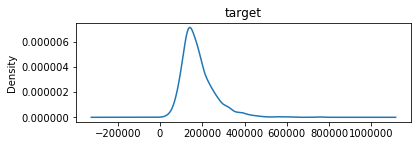

In [7]:
plt.subplot2grid((2,1),(0,0))
df_train.target.plot(kind='kde')
plt.title('target')

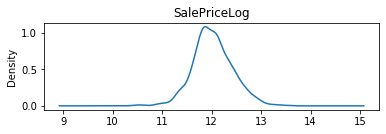

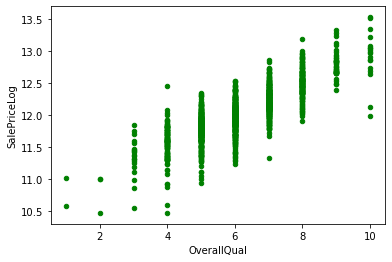

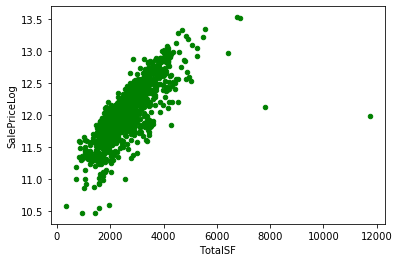

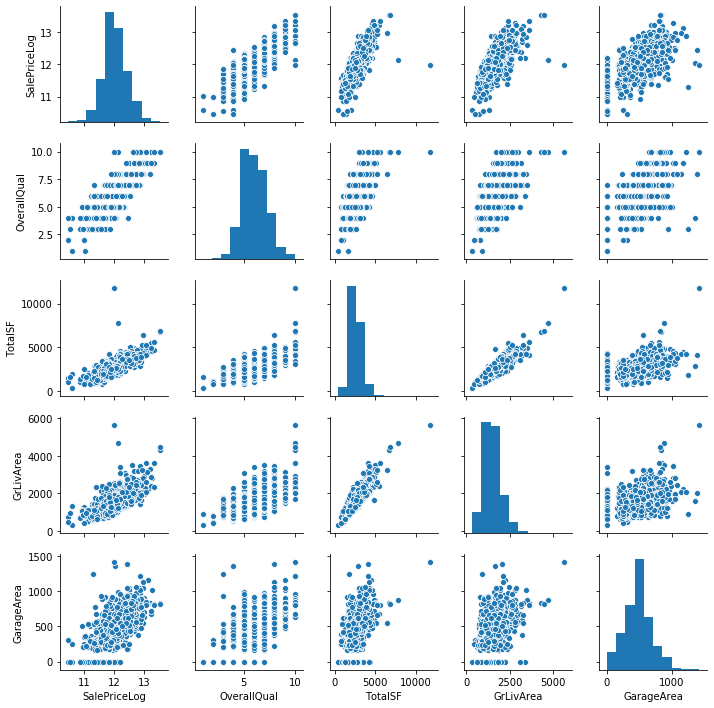

In [8]:
plt.subplot2grid((2,1),(1,0))
df_train.SalePriceLog.plot(kind='kde')
plt.title('SalePriceLog')

plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
plt.show() 

df_train.plot.scatter(x='OverallQual', y='SalePriceLog', color = 'green')
plt.show()

df_train.plot.scatter(x='TotalSF', y='SalePriceLog', color = 'green')
plt.show()

# correlation forte
col = ['SalePriceLog', 'OverallQual', 'TotalSF', 'GrLivArea', 'GarageArea']
sns.pairplot(df_train[col], height=2)
plt.show()

In [9]:
y_train = df_train.SalePriceLog.values.reshape((1459,1))
x_train = df_train.drop(['target','SalePriceLog'], axis=1).values.reshape((1459, 81))
x_test = df_test.values.reshape((1459,81))

In [10]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.8, subsample=0.5,
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.8, n_estimators=2000,
                             reg_alpha=0.1, reg_lambda=0.3, gamma=0.01, 
                             silent=1, random_state =7, nthread = -1)


xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)
y_test = xgb.predict(x_train)

In [11]:
RMSE = np.sqrt(mean_squared_error(y_train, y_test))
print(RMSE.round(4))

0.0382


In [12]:
submission = pd.DataFrame({"Id": df_test['Id'],"SalePrice": np.exp(xgb_pred)})

In [13]:
submission.to_csv("new_kagg1.csv")

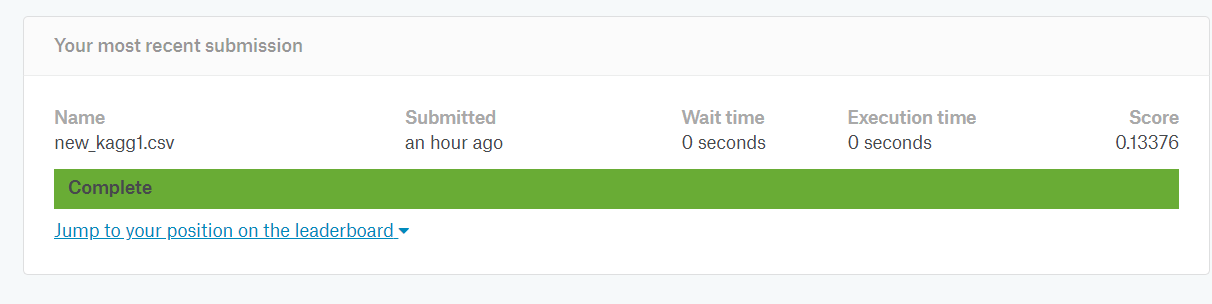

In [14]:
from IPython.display import Image
Image("png/Kagg2.png")


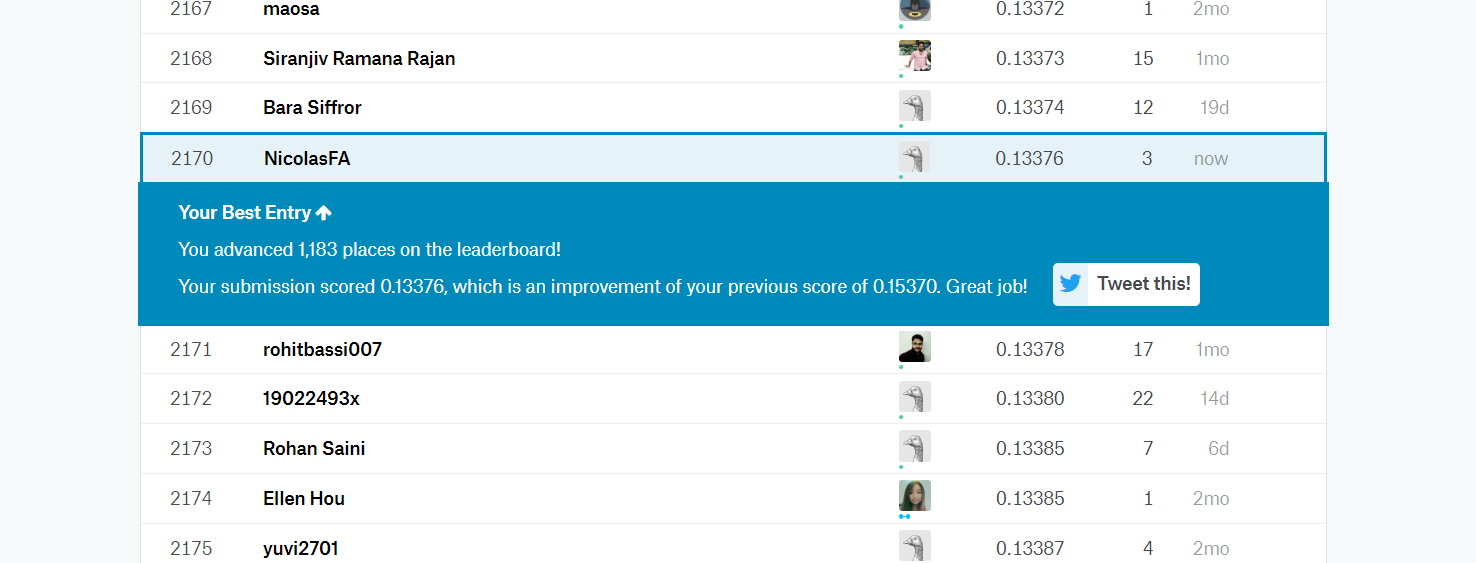

In [15]:
Image("png/idb2.png")

In [19]:
df_test.to_csv("new_kaggtest.csv")